# Supervised Fraud Detection using ETFD dataset from Kaggle
# Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load Dataset

In [2]:
df = pd.read_csv('../data/ETFD_Dataset.txt', sep='\t')
df

,blockNumber,confirmations,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
0,19664511,201879,4,16,0,0.175190,0.051997,0.700762,246.459167,43.0,0.0,6.0,0.0,0.0,0
1,16217669,3648727,12,19,8,0.084239,0.034468,13.394033,625.489433,62.0,0.0,1.0,0.0,0.0,0
2,14351953,5514270,3,9,10,3.896736,101.819168,467.608309,1884.806134,552.0,0.0,251.0,0.0,0.0,0
3,19753020,113094,4,28,9,0.135540,0.004389,1.490942,225.155556,59.0,0.0,33.0,0.0,0.0,0
4,19076055,790248,1,24,10,0.235717,0.149036,43.372003,937.681377,423.0,0.0,97.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84998,5950996,13816624,7,12,13,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1
84999,5951042,13816578,7,12,13,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1
85000,5951114,13816506,7,12,14,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1
85001,5957365,13810255,7,13,15,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.0,1


In [4]:
df.columns

Index(['blockNumber', 'confirmations', 'Month', 'Day', 'Hour',
       'mean_value_received', 'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')


Shape of Data: (85003, 15)

--- Class Balance (Fraud vs Normal) ---
Fraud
1    0.500029
0    0.499971
Name: proportion, dtype: float64


/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_23881/830461818.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='coolwarm')


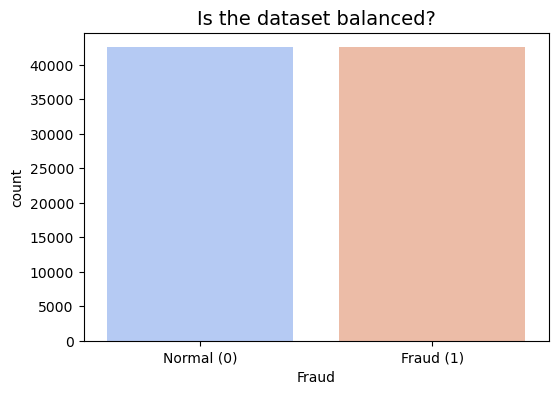


--- Top Features Correlated with Fraud ---
Fraud                                 1.000000
confirmations                         0.880294
total_tx_sent_malicious               0.218554
total_tx_sent_malicious_unique        0.209790
total_tx_received_malicious_unique    0.131387
Month                                 0.097111
Hour                                  0.062414
Day                                  -0.019343
variance_value_received              -0.115796
total_received                       -0.121746
Name: Fraud, dtype: float64
mean_value_received             -0.124467
total_tx_sent_unique            -0.205915
total_tx_sent                   -0.271143
time_diff_first_last_received   -0.376727
blockNumber                     -0.882195
Name: Fraud, dtype: float64


In [ ]:
y = df['Fraud']
X = df.drop(columns=['Fraud'])
print(f"\nShape of Data: {df.shape}")

print("\n--- Class Balance (Fraud vs Normal) ---")
print(y.value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='coolwarm')
plt.title("Is dataset balanced?", fontsize=14)
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

corr_matrix = df.select_dtypes(include=[np.number]).corr()
fraud_corr = corr_matrix['Fraud'].sort_values(ascending=False)

print("\n--- Top Features Correlated with Fraud ---")
print(fraud_corr.head(10))
print(fraud_corr.tail(5))

In [ ]:
# dropping non-informative columns
df_train = df.drop(columns=['blockNumber', 'confirmations'])
df_train.head()

,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
0,4,16,0,0.175190,0.051997,0.700762,246.459167,43.0,0.0,6.0,0.0,0.0,0
1,12,19,8,0.084239,0.034468,13.394033,625.489433,62.0,0.0,1.0,0.0,0.0,0
2,3,9,10,3.896736,101.819168,467.608309,1884.806134,552.0,0.0,251.0,0.0,0.0,0
3,4,28,9,0.135540,0.004389,1.490942,225.155556,59.0,0.0,33.0,0.0,0.0,0
4,1,24,10,0.235717,0.149036,43.372003,937.681377,423.0,0.0,97.0,0.0,0.0,0


In [ ]:
# check for missing values
df_train.isnull().sum().sum()

0

In [6]:
df_train.columns

Index(['Month', 'Day', 'Hour', 'mean_value_received',
       'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique',
       'Fraud'],
      dtype='object')

In [9]:
df_train.describe()

,Month,Day,Hour,mean_value_received,variance_value_received,total_received,time_diff_first_last_received,total_tx_sent,total_tx_sent_malicious,total_tx_sent_unique,total_tx_sent_malicious_unique,total_tx_received_malicious_unique,Fraud
count,85003.000000,85003.000000,85003.000000,85003.000000,8.500300e+04,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000,85003.000000
mean,6.058080,15.733951,12.138019,4.607558,4.079768e+03,3972.879905,304.783031,644.205369,49.362646,74.846217,12.049163,0.182076,0.500029
std,3.253529,8.736124,6.610912,31.713870,3.468387e+04,32287.360548,519.420096,1746.820366,215.433491,195.174043,51.611372,1.265924,0.500003
min,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,7.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,6.000000,16.000000,13.000000,0.000000,0.000000e+00,0.000000,0.000000,23.000000,0.000000,2.000000,0.000000,0.000000,1.000000
75%,9.000000,23.000000,18.000000,0.483130,3.821694e-01,22.876177,488.091528,437.000000,1.000000,45.000000,1.000000,0.000000,1.000000
max,12.000000,31.000000,23.000000,750.100000,1.124700e+06,281701.000000,2986.429039,9996.000000,1464.000000,1689.000000,293.000000,13.000000,1.000000


# Create train/validation/test split

In [ ]:
X = df_train.drop(columns=['Fraud'])
y = df_train['Fraud']

# Separate out TRAIN set (70%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Split the remaining 30% into VALIDATION (15%) and TEST (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Baseline XGBoost

In [11]:
model = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

print("Training Model")
model.fit(X_train, y_train)
print("Training Complete!")

# evaluate on VALIDATION set
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

Training Model
Training Complete!


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:48:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Validation Performance ---
ROC-AUC Score: 0.9991

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6375
           1       0.99      0.99      0.99      6375

    accuracy                           0.99     12750
   macro avg       0.99      0.99      0.99     12750
weighted avg       0.99      0.99      0.99     12750

[[6294   81]
 [  65 6310]]


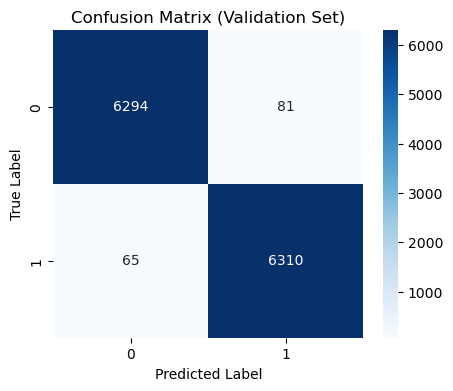

In [17]:
# metrics
print("\n--- Validation Performance ---")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# confusion matrix
print(confusion_matrix(y_val, y_pred))
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

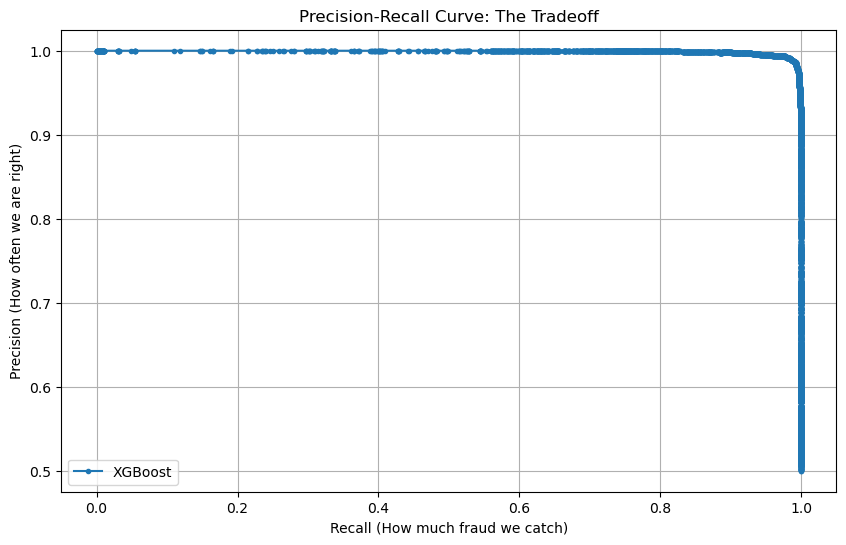

To achieve 0.9951 Precision (fewer false alerts):
We must accept a Recall of 0.9523 (catching slightly less fraud).
The threshold to set in our production engine is: 0.8725


In [14]:
from sklearn.metrics import precision_recall_curve

# 1. Get the probability scores (Risk Scores) instead of just Yes/No
y_scores = model.predict_proba(X_val)[:, 1]

# 2. Calculate the curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

# 3. Plot the Curve
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, marker='.', label='XGBoost')
plt.xlabel('Recall (How much fraud we catch)')
plt.ylabel('Precision (How often we are right)')
plt.title('Precision-Recall Curve: The Tradeoff')
plt.grid(True)
plt.legend()
plt.show()

# 4. Find the "Business Optimal" Threshold
# Let's say we want to minimize False Positives (High Precision)
# We look for the threshold where Precision is at least 99.5%
desired_precision = 0.995
idx = np.where(precisions >= desired_precision)[0][0]

print(f"To achieve {precisions[idx]:.4f} Precision (fewer false alerts):")
print(f"We must accept a Recall of {recalls[idx]:.4f} (catching slightly less fraud).")
print(f"The threshold to set in our production engine is: {thresholds[idx]:.4f}")

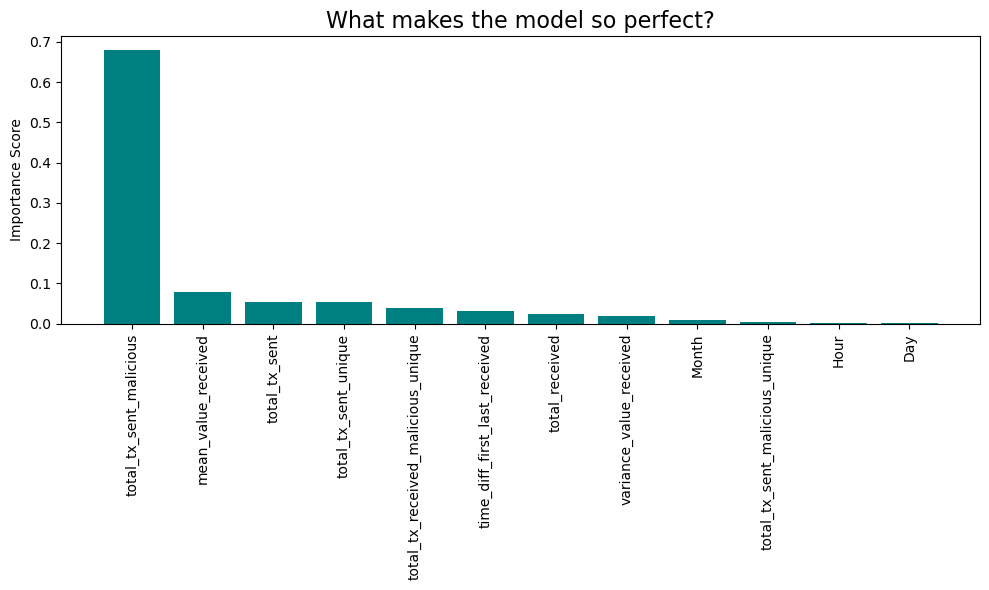

Top 3 Features Driving the Model:
1. total_tx_sent_malicious (0.6795)
2. mean_value_received (0.0784)
3. total_tx_sent (0.0549)


In [15]:
# --- INVESTIGATE: FEATURE IMPORTANCE ---
# This tells us exactly what the model is looking at.

features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # Sort descending

# Plot
plt.figure(figsize=(10, 6))
plt.title("What makes the model so perfect?", fontsize=16)
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color='teal')
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# Print Top 3 for clarity
print("Top 3 Features Driving the Model:")
for i in range(3):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --- BASELINE: LOGISTIC REGRESSION ---
# Logistic Regression requires scaling (StandardScaler) to work well.
# We use a Pipeline to keep it clean.

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()), # Step 1: Scale data
    ('classifier', LogisticRegression(random_state=42, max_iter=1000)) # Step 2: Linear Model
])

print("Training Logistic Regression Baseline...")
lr_pipeline.fit(X_train, y_train)

# Evaluate
y_prob_lr = lr_pipeline.predict_proba(X_val)[:, 1]
roc_lr = roc_auc_score(y_val, y_prob_lr)

print(f"\nLogistic Regression ROC-AUC: {roc_lr:.4f}")
print(f"XGBoost ROC-AUC (Recall): {roc_auc_score(y_val, y_prob):.4f}")

if roc_lr > 0.95:
    print("\nVERDICT: The dataset is 'Easy' (Linearly Separable).")
    print("Recommendation: To impress recruiters, we should make the task harder.")
else:
    print("\nVERDICT: The dataset is 'Hard'. XGBoost significantly outperformed the baseline.")

Training Logistic Regression Baseline...

Logistic Regression ROC-AUC: 0.8879
XGBoost ROC-AUC (Recall): 0.9991

VERDICT: The dataset is 'Hard'. XGBoost significantly outperformed the baseline.
